# Predicting Life Satisfaction with Brain Volume

---
author: Laura Rosok
---

## Introduction



This data comes from the Human Connectome Project (HCP), a large-scale neuroimaging study that provides data on brain connectivity and structure. This project includes information on brain volume and life satisfaction for 1206 participants. The goal of this analysis is to predict life satisfaction from brain volume.

The HCP dataset can be utilized by creating an account and requesting access [here](https://db.humanconnectome.org/app/template/Login.vm).

## Methods

In [142]:
# Imports

# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from tabulate import tabulate

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
import scipy.stats as stats
from sklearn.metrics import root_mean_squared_error

# Preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor


## Data

### Data Dictionary

| Variable Name                   | Data Type | Description                                               |
|---------------------------------|-----------|-----------------------------------------------------------|
| LifeSatisf_Unadj (Target)                | float64   | Unadjusted life satisfaction score                        |
| Gender                          | object    | Sex of participant (categorical)                   |
| Age                             | object    | Age of participant (categorical)                      |
| FS_IntraCranial_Vol             | float64   | Total intracranial volume                                 |
| FS_TotCort_GM_Vol               | float64   | Total cortical gray matter volume                         |
| FS_SubCort_GM_Vol               | float64   | Total subcortical gray matter volume                      |
| FS_ThalamusProper_Vol           | float64   | Thalamus proper volume                                    |
| FS_Caudate_Vol                  | float64   | Caudate volume                                            |
| FS_Hippo_Vol                    | float64   | Hippocampus volume                                        |
| FS_Amygdala_Vol                 | float64   | Amygdala volume                                           |
| FS_AccumbensArea_Vol            | float64   | Accumbens area volume                                     |
| FS_Pallidum_Vol                 | float64   | Pallidum volume                                           |
| FS_Frontalpole_Area             | float64   | Frontal pole area                                         |
| FS_Insula_Area                  | float64   | Insula area                                               |
| FS_Cerebellum_Cort_Vol          | float64   | Cerebellum cortical volume                                |
| FS_Lateralorbitofrontal_Area    | float64   | Lateral orbitofrontal cortex area                         |
| FS_BrainStem_Vol                | float64   | Brainstem volume                                          |
| FS_WM_Vol                       | float64   | White matter volume                                       |
| FS_CC_Anterior_Vol              | float64   | Anterior corpus callosum volume                           |


In [143]:
# import human connectome project data
df = pd.read_csv('unrestricted_laurarosok_HCP.csv', low_memory=False)

# only keep demophrapic, emotion, and brain volume data
df = df.iloc[:, list(range(3, 5)) + list(range(174, 191)) + list(range(191, 390))]

### Data Cleaning

In [144]:
# For numeric features, use median imputation
numeric_features = df.iloc[:,2:219].columns.tolist()
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])

# For categorical features, use mode imputation
categorical_features = df.select_dtypes(['category', 'object']).columns.tolist()
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])


In [145]:
# Average L and R brain volumes

# Select columns that start with 'FS_L' or 'FS_R'
fs_l_columns = [col for col in df.columns if col.startswith('FS_L')]
fs_r_columns = [col for col in df.columns if col.startswith('FS_R')]

# Average corresponding FS_L and FS_R columns 
averaged_columns = {}

for l_col in fs_l_columns:
    base_name = l_col.replace('FS_L', 'FS')
    r_col = l_col.replace('FS_L', 'FS_R')  

    if r_col in df.columns:  
        averaged_columns[base_name] = df[[l_col, r_col]].mean(axis=1)

averaged_df = pd.DataFrame(averaged_columns)

df = pd.concat([df, averaged_df], axis=1)

# Drop the original 'FS_L' and 'FS_R' columns
df = df.drop(columns=fs_l_columns + fs_r_columns)


# choose target variable and features
df_subset = df[[
    'LifeSatisf_Unadj',
    'Gender',
    'Age',
    'FS_IntraCranial_Vol',
    'FS_TotCort_GM_Vol',
    'FS_SubCort_GM_Vol',
    'FS_ThalamusProper_Vol',
    'FS_Caudate_Vol',
    'FS_Hippo_Vol',
    'FS_Amygdala_Vol',
    'FS_AccumbensArea_Vol',
    'FS_Pallidum_Vol',
    'FS_Frontalpole_Area',
    'FS_Insula_Area',
    'FS_Cerebellum_Cort_Vol',
    'FS_Lateralorbitofrontal_Area',
    'FS_BrainStem_Vol',
    'FS_WM_Vol',  
    'FS_CC_Anterior_Vol'
]]  

In [146]:
# Summary statistics 

# Calculate mean and standard deviation
mean_sd = df_subset.describe().loc[['mean', 'std']]

# Transpose the result so that variables are rows
mean_sd_transposed = mean_sd.T

# Format the output table with tabulate
formatted_table = tabulate(mean_sd_transposed, headers='keys', tablefmt='fancy_grid', showindex=True, floatfmt=".2f")
print(formatted_table)

╒══════════════════════════════╤════════════╤═══════════╕
│                              │       mean │       std │
╞══════════════════════════════╪════════════╪═══════════╡
│ LifeSatisf_Unadj             │      54.37 │      9.21 │
├──────────────────────────────┼────────────┼───────────┤
│ FS_IntraCranial_Vol          │ 1579446.84 │ 182762.22 │
├──────────────────────────────┼────────────┼───────────┤
│ FS_TotCort_GM_Vol            │  509840.15 │  51821.31 │
├──────────────────────────────┼────────────┼───────────┤
│ FS_SubCort_GM_Vol            │   60908.33 │   5258.27 │
├──────────────────────────────┼────────────┼───────────┤
│ FS_ThalamusProper_Vol        │    7923.78 │    784.95 │
├──────────────────────────────┼────────────┼───────────┤
│ FS_Caudate_Vol               │    3866.99 │    456.36 │
├──────────────────────────────┼────────────┼───────────┤
│ FS_Hippo_Vol                 │    4452.56 │    434.17 │
├──────────────────────────────┼────────────┼───────────┤
│ FS_Amygdala_

## Visualizations

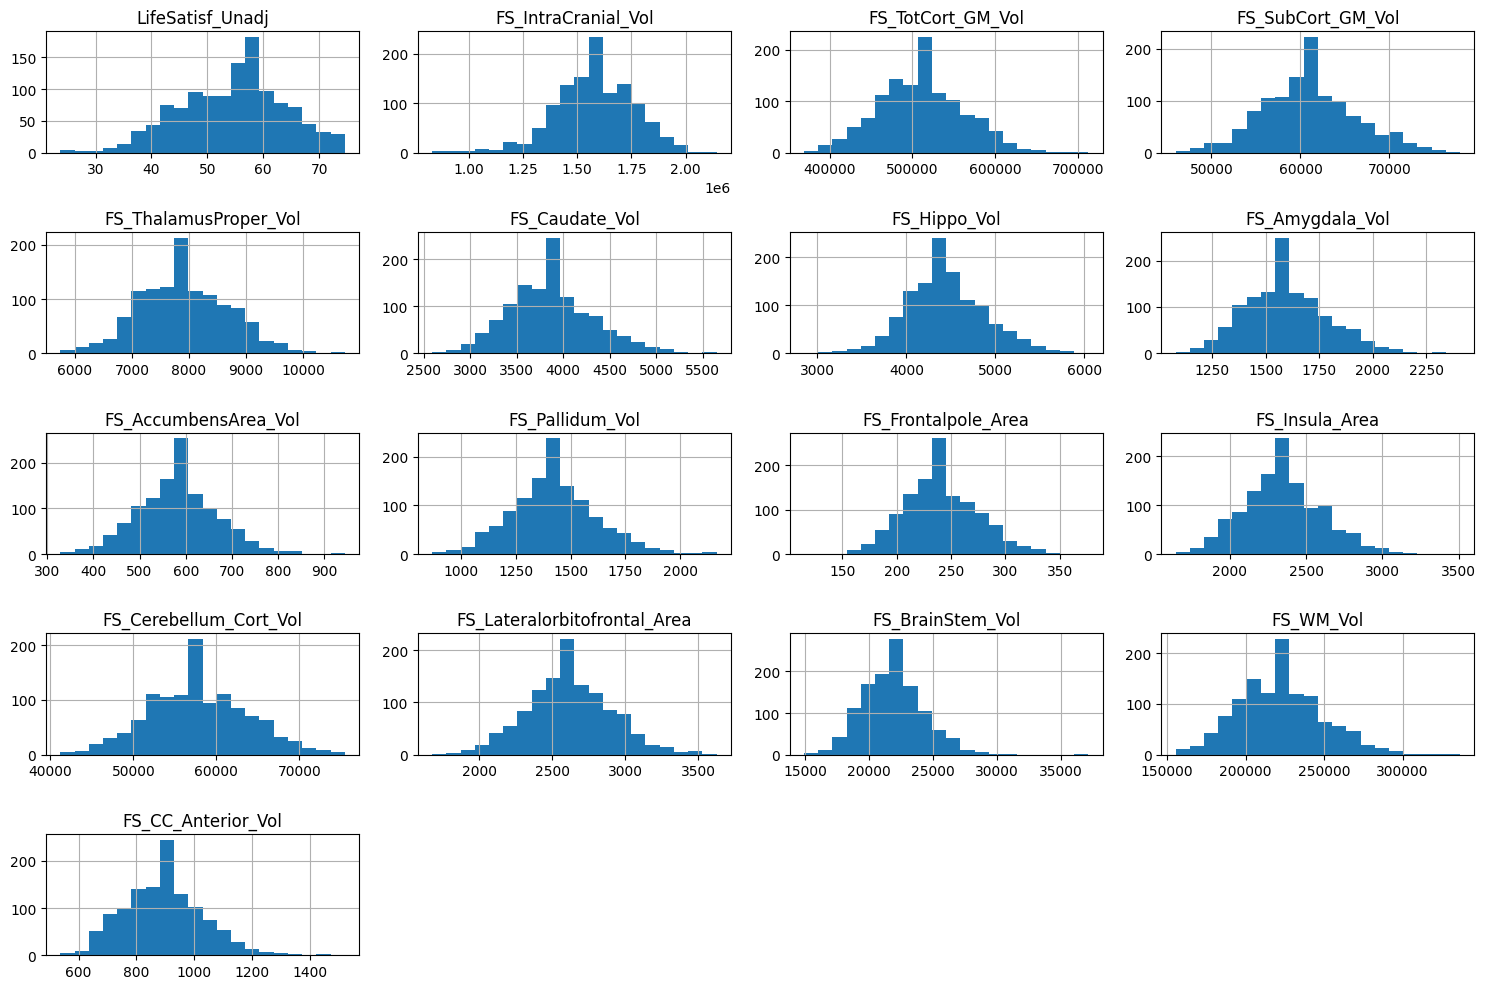

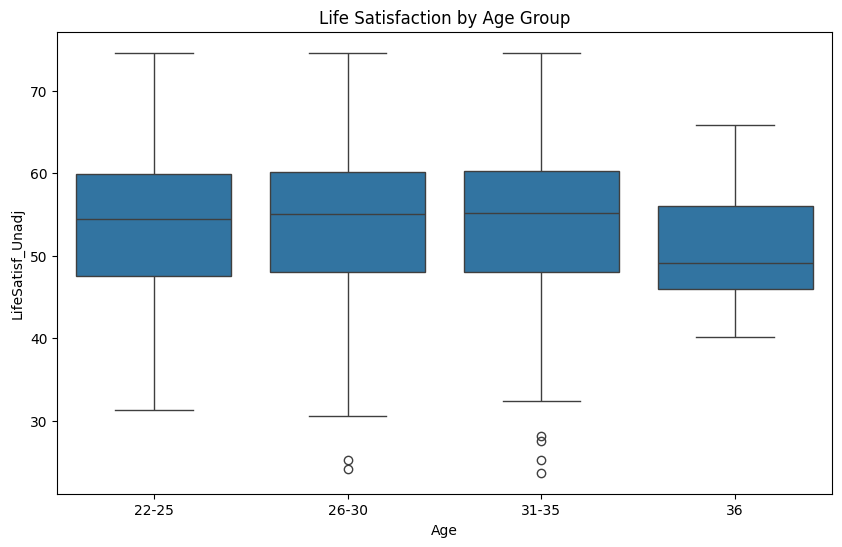

In [147]:
# Plot histograms for all columns in the subset
df_subset.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Life Satisfaction by Age
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='LifeSatisf_Unadj', data=df_subset)
plt.title("Life Satisfaction by Age Group")
plt.show()

### Models

In [148]:
# process data for ML

df_subset.loc[:, 'LifeSatisf_Unadj'] = np.log1p(df_subset['LifeSatisf_Unadj'])  # Apply log transformation to target 

X = df_subset.drop('LifeSatisf_Unadj', axis=1)
y = df_subset['LifeSatisf_Unadj']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [149]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(['int', 'float']).columns.tolist()
cat_features = X_train.select_dtypes(['category', 'object']).columns.tolist()

# Pipeline for numeric features
Numeric_pipeline = Pipeline(steps=[
    ('Standardize', StandardScaler())  
])

# Pipeline for categorical features
Categorical_pipeline = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=5))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('Numeric_processing', Numeric_pipeline, numeric_features),
    ('Categorical_processing', Categorical_pipeline, cat_features)
])

# pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0))  
])


In [150]:
baseline_param_grid = {}

param_grid = [
    # K-Nearest Neighbors
    {
        "regressor": [KNeighborsRegressor()],
        "regressor__n_neighbors": [1, 3, 5, 10, 15],  
    },
    # Voting Regressor with Random Forest and SVR
    {
        "regressor": [VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('svr', SVR())
        ])]
    },
    # Voting Regressor with SVR, Lasso, and Ridge
    {
        "regressor": [VotingRegressor(estimators=[
            ('svr', SVR()),
            ('lasso', Lasso(alpha=0.1)),  
            ('ridge', Ridge(alpha=1.0))   
        ])]
    }
]

In [151]:
# baseline model

baseline_mod = GridSearchCV(
    pipeline,
    param_grid=baseline_param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    scoring="neg_mean_squared_error",

)

# Fit model on the training data
baseline_mod.fit(X_train, y_train)

# Predict on the training set
baseline_train_y_pred = baseline_mod.predict(X_train)
baseline_train_y_pred_inverse = np.expm1(baseline_train_y_pred)

# Predict on the test set
baseline_test_y_pred = baseline_mod.predict(X_test)
baseline_test_y_pred_inverse = np.expm1(baseline_test_y_pred)

# Calculate RMSE on the training set
y_train_inverse = np.expm1(y_train)
baseline_train_rmse = root_mean_squared_error(y_train_inverse, baseline_train_y_pred_inverse)

# Calculate RMSE on the test set
y_test_inverse = np.expm1(y_test)
baseline_test_rmse = root_mean_squared_error(y_test_inverse, baseline_test_y_pred_inverse)

if baseline_train_rmse < baseline_test_rmse:
    print("Based on RMSE, the baseline model is overfitting.\n")
elif baseline_train_rmse > baseline_test_rmse:
    print("Based on RMSE, the baseline model is underfitting.\n")
else:
    print("Based on RMSE, the baseline model is neither overfitting nor underfitting.\n")

print(f"Baseline Training Root Mean Squared Error: {baseline_train_rmse}")
print(f"Baseline Test Root Mean Squared Error: {baseline_test_rmse}")

Based on RMSE, the baseline model is underfitting.

Baseline Training Root Mean Squared Error: 9.298991491895691
Baseline Test Root Mean Squared Error: 8.979497643441327


In [152]:
# full pipeline

mod = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    scoring="neg_mean_squared_error"
)

mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
train_y_pred = mod.predict(X_train)

# Print best parameters
best_params = mod.best_params_

regressor = best_params['regressor']
estimators = regressor.estimators

formatted_output = f"\033[1mBest regressor configuration:\033[0m\n"
formatted_output += f"VotingRegressor with the following estimators:\n"
for name, model in estimators:
    formatted_output += f"    \033[1m{name}:\033[0m {repr(model)}\n"

print(formatted_output)


Best regressor configuration:
VotingRegressor with the following estimators:
    svr: SVR()
    lasso: Lasso(alpha=0.1)
    ridge: Ridge()



## Results

In [153]:
# Predict on the training set
train_y_pred = mod.predict(X_train)
train_y_pred_inverse = np.expm1(train_y_pred)  # Reverse log transformation

# Predict on the test set
test_y_pred = mod.predict(X_test)
test_y_pred_inverse = np.expm1(test_y_pred)  # Reverse log transformation

# Calculate RMSE on the training set
train_rmse = root_mean_squared_error(y_train_inverse, train_y_pred_inverse)

# Calculate RMSE on the test set
test_rmse = root_mean_squared_error(y_test_inverse, test_y_pred_inverse)

# Print whether the model is overfitting, underfitting, or neither
if train_rmse < test_rmse:
    print("Based on RMSE, the model is overfitting.\n")
elif train_rmse > test_rmse:
    print("Based on RMSE, the model is underfitting.\n")
else:
    print("Based on RMSE, the model is neither overfitting nor underfitting.\n")

# Print RMSE for both training and test sets
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Based on RMSE, the model is overfitting.

Training RMSE: 8.12131488752707
Test RMSE: 8.766067265705688


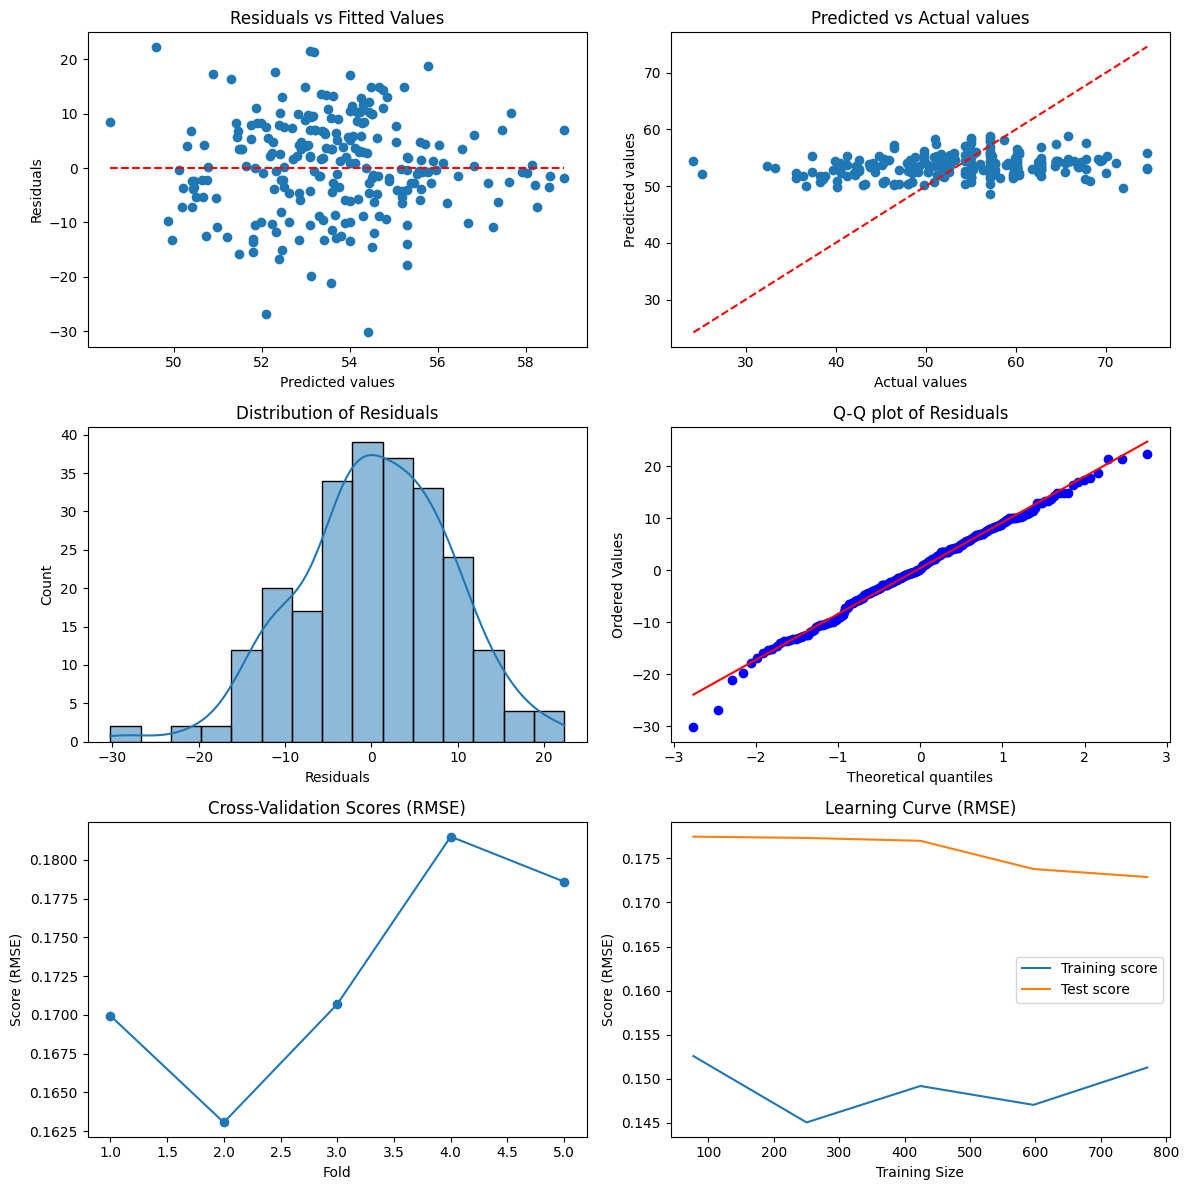

In [154]:
# Calculate residuals
residuals = y_test_inverse - test_y_pred_inverse

# Create subplots with 2 plots per row
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  

# 1: Residuals vs Fitted Values
axes[0, 0].scatter(test_y_pred_inverse, residuals)
axes[0, 0].hlines(y=0, xmin=min(test_y_pred_inverse), xmax=max(test_y_pred_inverse), colors='red', linestyles='dashed')
axes[0, 0].set_xlabel('Predicted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')

# 2t: Predicted vs Actual values
axes[0, 1].scatter(y_test_inverse, test_y_pred_inverse)
axes[0, 1].plot([min(y_test_inverse), max(y_test_inverse)], [min(y_test_inverse), max(y_test_inverse)], color='red', linestyle='--')
axes[0, 1].set_xlabel('Actual values')
axes[0, 1].set_ylabel('Predicted values')
axes[0, 1].set_title('Predicted vs Actual values')

# 3: Distribution of residuals
sns.histplot(residuals, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_title('Distribution of Residuals')

# 4: Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot of Residuals')

# 5: Cross-validation scores (using negative RMSE)
cv_scores = cross_val_score(mod, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')  
cv_scores = -cv_scores  # Convert negative values to positive
axes[2, 0].plot(range(1, 6), cv_scores, marker='o')
axes[2, 0].set_title('Cross-Validation Scores (RMSE)')
axes[2, 0].set_xlabel('Fold')
axes[2, 0].set_ylabel('Score (RMSE)')

# 6: Learning curve
train_sizes, train_scores, test_scores = learning_curve(mod, X_train, y_train, cv=5)
train_scores_mean = np.sqrt(-train_scores.mean(axis=1))  # Convert to RMSE
test_scores_mean = np.sqrt(-test_scores.mean(axis=1))  # Convert to RMSE
axes[2, 1].plot(train_sizes, train_scores_mean, label='Training score')
axes[2, 1].plot(train_sizes, test_scores_mean, label='Test score')
axes[2, 1].set_title('Learning Curve (RMSE)')
axes[2, 1].set_xlabel('Training Size')
axes[2, 1].set_ylabel('Score (RMSE)')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

## Discussion

This model is able to predict life satisfaction with an RMSE value of 8.77. Based on the above figure, we can see that that the model is not able to explain much of the variance in life satisfaction. This suggests that brain volume is not a strong predictor of life satisfaction.